In [1]:
# Bronte Sihan Li, Cole Crescas, Karan Shah
# 2023-09-23
# CS 7180

In [ ]:
#Please run these prior to starting
%pip install pytorch==1.10.2 torchvision torchaudio cudatoolkit==11.3
%pip install -r Dehaze/requirements.txt
%pip install image_dehazer

In [1]:
#path to our data
DATASET_DIR = 'data/a2i2/'
IMAGE_DIR = DATASET_DIR + 'UAV-train/paired_dehaze/images/'

In [3]:
# Explore the training dataset

import sys, os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from tqdm import tqdm
from datetime import datetime
from tensorboardX import SummaryWriter
from collections import OrderedDict
from Dehaze.utils import AverageMeter, write_img, chw_to_hwc
from pytorch_msssim import ssim

# seed everything

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



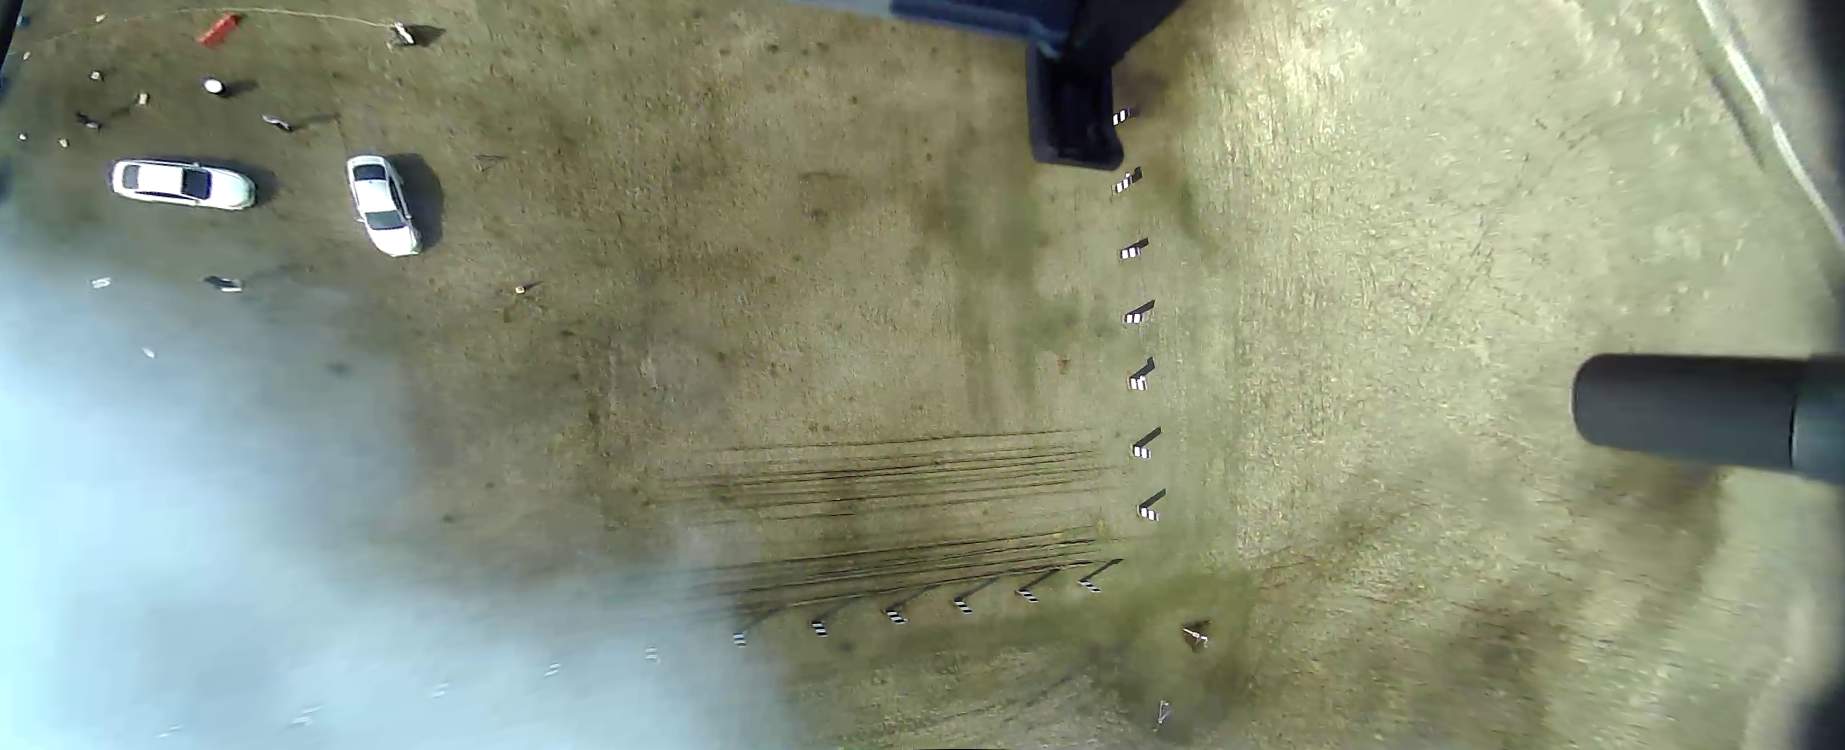

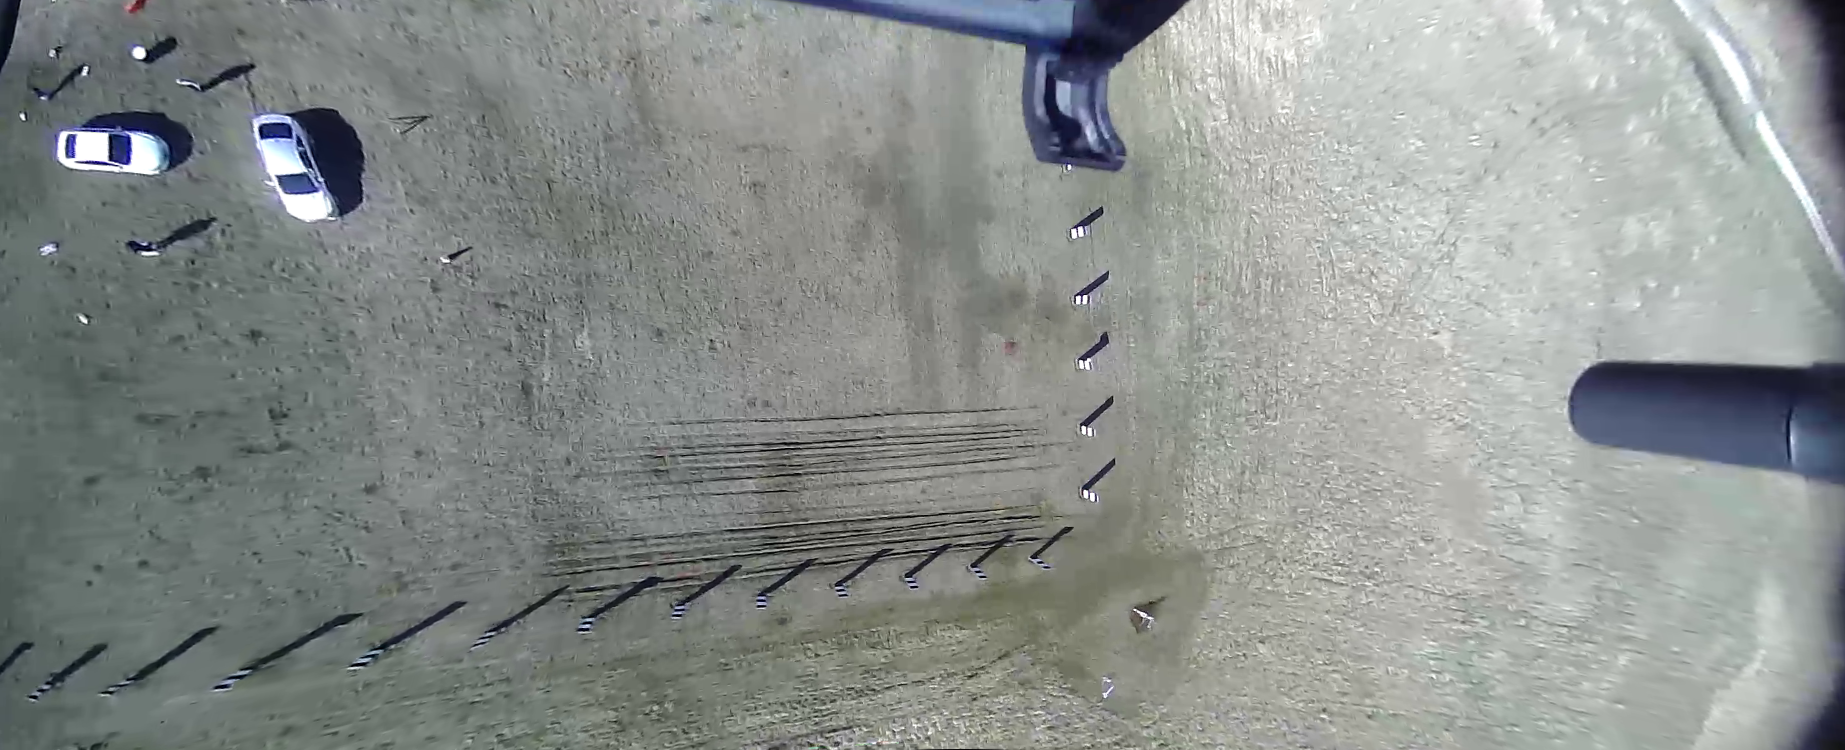

In [18]:
# First split the paired images into input and target images
def split_paired_image(paired_image):
    w, h = paired_image.size
    h2 = int(h / 2)
    target_image = paired_image.crop((0, 0, w, h2))
    input_image = paired_image.crop((0, h2, w, h))
    return input_image, target_image

img = Image.open(IMAGE_DIR + '000.png')
input_img, target_img = split_paired_image(img)
input_img.show()
target_img.show()

In [4]:
# Make directory for train and validation images
train_dir = IMAGE_DIR + 'train/'
val_dir = IMAGE_DIR + 'val/'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
# Make directory for hazy and GT images
os.makedirs(train_dir+'hazy', exist_ok=True)
os.makedirs(train_dir+'GT', exist_ok=True)
os.makedirs(val_dir+'hazy', exist_ok=True)
os.makedirs(val_dir+'GT', exist_ok=True)

In [21]:
# Process all images and split into train and validation sets
for filename in tqdm(os.listdir(IMAGE_DIR)):
    if filename.endswith('.png'):
        img = Image.open(IMAGE_DIR + filename)
        input_img, target_img = split_paired_image(img)
        # Randomly assign to train or validation set
		#This may need a seed value to achieve repeated results
        if random.random() < 0.8:
            input_img.save(train_dir + 'hazy/' + filename)
            target_img.save(train_dir + 'GT/' + filename)
        else:
            input_img.save(val_dir + 'hazy/' + filename)
            target_img.save(val_dir + 'GT/' + filename)

100%|██████████| 229/229 [02:05<00:00,  1.83it/s]


In [5]:
sys.path.append('Dehaze')
from Dehaze.datasets.loader import PairLoader, SingleLoader

# Load the dataset
train_dataset = PairLoader(data_dir=train_dir, sub_dir='', mode='train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,)
val_dataset = PairLoader(data_dir=val_dir, sub_dir='', mode='valid')
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,)

#Adjusting format to fit our dataset
# The dataset format is {'source': img, 'target': img, 'filename': img_name}
# Explore the dataset
for batch in train_loader:
    print(batch['source'].shape)
    print(batch['target'].shape)
    print(batch['filename'])
    break

for batch in val_loader:
    print(batch['source'].shape)
    print(batch['target'].shape)
    print(batch['filename'])
    break

torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256])
['018.png', '097.png', '139.png', '126.png', '191.png', '156.png', '101.png', '025.png', '084.png', '078.png', '043.png', '223.png', '196.png', '212.png', '186.png', '067.png', '058.png', '027.png', '121.png', '182.png', '167.png', '187.png', '199.png', '070.png', '005.png', '222.png', '192.png', '190.png', '154.png', '009.png', '164.png', '041.png']
torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256])
['007.png', '016.png', '023.png', '029.png', '030.png', '035.png', '042.png', '046.png', '047.png', '051.png', '052.png', '060.png', '074.png', '077.png', '080.png', '081.png', '083.png', '089.png', '090.png', '093.png', '094.png', '096.png', '098.png', '103.png', '107.png', '115.png', '118.png', '124.png', '127.png', '128.png', '130.png', '135.png']


In [6]:
#These functions are similar to train_test_dehazeformer.py
def train(train_loader, network, criterion, optimizer, scaler):
	losses = AverageMeter()

	torch.cuda.empty_cache()
	
	network.train()

	for batch in train_loader:
		source_img = batch['source'].cuda()
		target_img = batch['target'].cuda()

		with autocast():
			output = network(source_img)
			loss = criterion(output, target_img)

		losses.update(loss.item())

		optimizer.zero_grad()
		scaler.scale(loss).backward()
		scaler.step(optimizer)
		scaler.update()

	return losses.avg


def valid(val_loader, network):
	PSNR = AverageMeter()

	torch.cuda.empty_cache()

	network.eval()

	for batch in val_loader:
		source_img = batch['source'].cuda()
		target_img = batch['target'].cuda()

		with torch.no_grad():							# torch.no_grad() may cause warning
			output = network(source_img).clamp_(-1, 1)		

		mse_loss = F.mse_loss(output * 0.5 + 0.5, target_img * 0.5 + 0.5, reduction='none').mean((1, 2, 3))
		psnr = 10 * torch.log10(1 / mse_loss).mean()
		PSNR.update(psnr.item(), source_img.size(0))

	return PSNR.avg

In [7]:
from Dehaze.models import *
from torch.cuda.amp import autocast, GradScaler
import json

#Some models are trained on outdoor/real world data vs syntehtic images.  Since we are using a real world dataset, we would like to test on that
settings = json.load(open('Dehaze/configs/outdoor/dehazeformer-s.json', 'r'))

# We pick DehazeFormer_s as the first model to train
model = dehazeformer_s()
model = nn.DataParallel(model).cuda()

criterion = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=settings['lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=settings['epochs'], eta_min=settings['lr'] * 1e-2)
scaler = GradScaler()

# Load the pretrained model
checkpoint = torch.load('models/outdoor/dehazeformer-s.pth')
model.load_state_dict(checkpoint['state_dict'])

/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [8]:
#Finetuning steps to use our dataset.  We test unfreezing the 5th layer and 4th & 5th layers to compare results for 30 epochs
# Freeze all of the parameters except the last layer or 2
for param in model.parameters():
    param.requires_grad = False
#Unfreeze the fourth layer
for param in model.module.layer4.parameters():
    param.requires_grad = True
#Unfreeze the fifth layer
for param in model.module.layer5.parameters():
    param.requires_grad = True

#Check for GPU, else run on CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


DataParallel(
  (module): DehazeFormer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    )
    (layer1): BasicLayer(
      (blocks): ModuleList(
        (0): TransformerBlock(
          (norm1): Identity()
          (attn): Attention(
            (conv): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=24, padding_mode=reflect)
            (V): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
            (proj): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
          )
          (norm2): Identity()
          (mlp): Mlp(
            (mlp): Sequential(
              (0): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
              (1): ReLU(inplace=True)
              (2): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1))
            )
          )
        )
        (1): TransformerBlock(
          (norm1): Identity()
          (attn): Attention(
            (conv): Conv2

In [9]:
# Make directory for saving the model and logs
save_dir = 'models/finetune/dehazeformer-s/unfreeze_last2/'
os.makedirs(save_dir, exist_ok=True)
log_dir = 'logs/finetune/dehazeformer-s/unfreeze_last2/'
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

#Start training with 30 epochs and create variable to save the best_psnr.  In addition, there are logs generated to read from
best_psnr = 0
print(f'Start training for {settings["epochs"]} epochs (eval every {settings["eval_freq"]} epochs')
for epoch in tqdm(range(settings['epochs'] + 1)):
    print(f'Epoch: {epoch}')
    loss = train(train_loader, model, criterion, optimizer, scaler)

    writer.add_scalar('train_loss', loss, epoch)

    scheduler.step()

    if epoch % settings['eval_freq'] == 0:
        avg_psnr = valid(val_loader, model)
        
        writer.add_scalar('valid_psnr', avg_psnr, epoch)

        if avg_psnr > best_psnr:
            best_psnr = avg_psnr
            torch.save({'state_dict': model.state_dict()}, save_dir + f'dehazeformer-s_{datetime.now()}.pth')
        
        writer.add_scalar('best_psnr', best_psnr, epoch)

Start training for 30 epochs (eval every 1 epochs


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 0


  3%|▎         | 1/31 [00:28<14:27, 28.93s/it]

Epoch: 1


  6%|▋         | 2/31 [00:53<12:50, 26.56s/it]

Epoch: 2


 10%|▉         | 3/31 [01:18<12:00, 25.74s/it]

Epoch: 3


 13%|█▎        | 4/31 [01:44<11:32, 25.65s/it]

Epoch: 4


 16%|█▌        | 5/31 [02:09<10:59, 25.38s/it]

Epoch: 5


 19%|█▉        | 6/31 [02:34<10:33, 25.36s/it]

Epoch: 6


 23%|██▎       | 7/31 [02:59<10:06, 25.27s/it]

Epoch: 7


 26%|██▌       | 8/31 [03:25<09:47, 25.56s/it]

Epoch: 8


 29%|██▉       | 9/31 [03:50<09:18, 25.39s/it]

Epoch: 9


 32%|███▏      | 10/31 [04:15<08:50, 25.27s/it]

Epoch: 10


 35%|███▌      | 11/31 [04:40<08:23, 25.17s/it]

Epoch: 11


 39%|███▊      | 12/31 [05:05<07:57, 25.15s/it]

Epoch: 12


 42%|████▏     | 13/31 [05:31<07:36, 25.38s/it]

Epoch: 13


 45%|████▌     | 14/31 [05:56<07:10, 25.33s/it]

Epoch: 14


 48%|████▊     | 15/31 [06:22<06:48, 25.56s/it]

Epoch: 15


 52%|█████▏    | 16/31 [06:47<06:21, 25.43s/it]

Epoch: 16


 55%|█████▍    | 17/31 [07:13<05:54, 25.35s/it]

Epoch: 17


 58%|█████▊    | 18/31 [07:38<05:31, 25.48s/it]

Epoch: 18


 61%|██████▏   | 19/31 [08:04<05:05, 25.42s/it]

Epoch: 19


 65%|██████▍   | 20/31 [08:29<04:38, 25.35s/it]

Epoch: 20


 68%|██████▊   | 21/31 [08:54<04:12, 25.28s/it]

Epoch: 21


 71%|███████   | 22/31 [09:19<03:46, 25.16s/it]

Epoch: 22


 74%|███████▍  | 23/31 [09:44<03:21, 25.23s/it]

Epoch: 23


 77%|███████▋  | 24/31 [10:10<02:56, 25.26s/it]

Epoch: 24


 81%|████████  | 25/31 [10:35<02:30, 25.15s/it]

Epoch: 25


 84%|████████▍ | 26/31 [11:01<02:07, 25.51s/it]

Epoch: 26


 87%|████████▋ | 27/31 [11:26<01:42, 25.53s/it]

Epoch: 27


 90%|█████████ | 28/31 [11:52<01:16, 25.45s/it]

Epoch: 28


 94%|█████████▎| 29/31 [12:17<00:50, 25.33s/it]

Epoch: 29


 97%|█████████▋| 30/31 [12:44<00:25, 25.76s/it]

Epoch: 30


100%|██████████| 31/31 [13:09<00:00, 25.47s/it]


In [10]:
def single(save_dir):
	state_dict = torch.load(save_dir)['state_dict']
	new_state_dict = OrderedDict()

	for k, v in state_dict.items():
		name = k[7:]
		new_state_dict[name] = v

	return new_state_dict

def test(test_loader, network, result_dir):
	PSNR = AverageMeter()
	SSIM = AverageMeter()

	torch.cuda.empty_cache()

	network.eval()

	os.makedirs(os.path.join(result_dir, 'imgs'), exist_ok=True)
	f_result = open(os.path.join(result_dir, 'results.csv'), 'w')

	for idx, batch in enumerate(test_loader):
		input = batch['source'].cuda()
		target = batch['target'].cuda()


		filename = batch['filename'][0]

		with torch.no_grad():
			output = network(input).clamp_(-1, 1)

			# [-1, 1] to [0, 1]
			output = output * 0.5 + 0.5
			target = target * 0.5 + 0.5

			psnr_val = 10 * torch.log10(1 / F.mse_loss(output, target)).item()

			_, _, H, W = output.size()
			down_ratio = max(1, round(min(H, W) / 256))		# Zhou Wang
			ssim_val = ssim(F.adaptive_avg_pool2d(output, (int(H / down_ratio), int(W / down_ratio))), 
							F.adaptive_avg_pool2d(target, (int(H / down_ratio), int(W / down_ratio))), 
							data_range=1, size_average=False).item()				

		PSNR.update(psnr_val)
		SSIM.update(ssim_val)

		print('Test: [{0}]\t'
			  'PSNR: {psnr.val:.02f} ({psnr.avg:.02f})\t'
			  'SSIM: {ssim.val:.03f} ({ssim.avg:.03f})'
			  .format(idx, psnr=PSNR, ssim=SSIM))

		f_result.write('%s,%.02f,%.03f\n'%(filename, psnr_val, ssim_val))

		input_img = chw_to_hwc(input.detach().cpu().squeeze(0).numpy() *0.5 +0.5)
		out_img = chw_to_hwc(output.detach().cpu().squeeze(0).numpy())
		target_img = chw_to_hwc(target.detach().cpu().squeeze(0).numpy())
		# concactenate output and target image
		out_img = np.concatenate((input_img, out_img, target_img), axis=1)
		write_img(os.path.join(result_dir, 'imgs', f'dehaze_{filename}'), out_img)

	f_result.close()

	os.rename(os.path.join(result_dir, 'results.csv'), 
			  os.path.join(result_dir, '%.02f | %.04f.csv'%(PSNR.avg, SSIM.avg)))


In [11]:
from Dehaze.models import *
# See the output of some examples
#Load our finetuned model and test
result_dir = 'results/finetune/dehazeformer-s/'
os.makedirs(result_dir, exist_ok=True)

test_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

model = dehazeformer_s()
model = model.cuda()
saved_model_dir = '/notebooks/models/finetune/dehazeformer-s/unfreeze_last2/dehazeformer-s_2023-09-16 01:50:39.864922.pth'
model.load_state_dict(single(saved_model_dir))
test(test_loader, model, result_dir)

Test: [0]	PSNR: 15.24 (15.24)	SSIM: 0.452 (0.452)
Test: [1]	PSNR: 13.69 (14.47)	SSIM: 0.480 (0.466)
Test: [2]	PSNR: 14.99 (14.64)	SSIM: 0.237 (0.390)
Test: [3]	PSNR: 16.37 (15.07)	SSIM: 0.637 (0.452)
Test: [4]	PSNR: 14.09 (14.88)	SSIM: 0.566 (0.474)
Test: [5]	PSNR: 16.32 (15.12)	SSIM: 0.427 (0.467)
Test: [6]	PSNR: 15.32 (15.15)	SSIM: 0.509 (0.473)
Test: [7]	PSNR: 14.90 (15.12)	SSIM: 0.373 (0.460)
Test: [8]	PSNR: 16.34 (15.25)	SSIM: 0.280 (0.440)
Test: [9]	PSNR: 12.34 (14.96)	SSIM: 0.292 (0.425)
Test: [10]	PSNR: 14.24 (14.89)	SSIM: 0.440 (0.427)
Test: [11]	PSNR: 15.45 (14.94)	SSIM: 0.499 (0.433)
Test: [12]	PSNR: 17.70 (15.15)	SSIM: 0.570 (0.443)
Test: [13]	PSNR: 16.54 (15.25)	SSIM: 0.593 (0.454)
Test: [14]	PSNR: 11.95 (15.03)	SSIM: 0.439 (0.453)
Test: [15]	PSNR: 12.71 (14.89)	SSIM: 0.445 (0.452)
Test: [16]	PSNR: 17.12 (15.02)	SSIM: 0.559 (0.459)
Test: [17]	PSNR: 17.74 (15.17)	SSIM: 0.600 (0.467)
Test: [18]	PSNR: 16.67 (15.25)	SSIM: 0.506 (0.469)
Test: [19]	PSNR: 17.51 (15.36)	SSIM: 0.76

In [1]:
%pip install image_dehazer

  Preparing metadata (setup.py) ... done
  Created wheel for image_dehazer: filename=image_dehazer-0.0.9-py3-none-any.whl size=6393 sha256=4bdb7bff8fbf14d88e84a32404ca8541c8cb2297f3a0e1d87cb5f3cfb2009344
  Stored in directory: /root/.cache/pip/wheels/0a/74/3e/d3dca52ce4583b51c1575f2fac26dc10356a0fbbe285332cd4
Successfully built image_dehazer
Note: you may need to restart the kernel to use updated packages.
